In [1]:
###--------------------------------------------LOAD LIBRARIES

import pandas as pd
import scanpy as sc
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import random
import pickle

In [2]:
###--------------------------------------------LOAD DATA
adata1 = sc.read("../LIBD_LR/grantpm/DLPFC_Visium_LIBD/processed-data/MGP_analysis/nonIF_c2l_anndata_combined_30samples.h5ad")
adata2 = sc.read("../LIBD_LR/grantpm/DLPFC_Visium_LIBD/processed-data/MGP_analysis/IF_c2l_anndata_combined.h5ad")

adata = adata1.concatenate(adata2, join = 'inner')
if (adata.var['gene_name-1'].astype(str).equals(adata.var['gene_name-0'].astype(str))==True):
    adata.var['gene_name'] = adata.var['gene_name-1']
    adata.var.drop(columns = ['gene_name-1', 'gene_name-0'], inplace = True)

/camp/lab/gandhis/home/users/grantpm/.conda/envs/panpipes/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [12]:
def coloc_LR_list(original, gene_list, res):
    adata = copy.copy(original)
    counter = 0
    for n in range(0,len(gene_list)):
        gene = adata.var['gene_name'].eq(gene_list[n])
        if (gene.sum()>0):
            counter+=1
            if (counter==1):
                df = (adata.to_df()[adata.var[gene].index]>0).astype(int)
            else: 
                df[adata.var[gene].index[0]] = (adata.to_df()[adata.var[gene].index]>0).astype(int)
                
    df['sum'] = df.sum(axis=1)
    print(counter)
    print(counter/len(gene_list)*100)
    df['sum'].hist(bins = len(gene_list))
    df.to_csv("processed_data/03-LR_network_visualisation/03h_spatial_colocalisation/%s_dataframe_counts_expression_network.csv" % (res))
    return df

In [11]:
def hot1_encode_cell_counts(adata):
    probs = adata.obs[['Astro', 'EndoMural', 'Excit_L2_3', 'Excit_L3',
       'Excit_L3_4_5', 'Excit_L4', 'Excit_L5', 'Excit_L5_6', 'Excit_L6',
       'Inhib', 'Micro', 'OPC', 'Oligo']]

    cells = []

    for n in range (0,len(probs.columns)):
        cells.append(probs.columns[n].replace('prop_',''))
    probs.columns = cells

    print("Building adjacency matrix for top 3 cells per spot...")
    hot1 = copy.copy(probs)
    hot1.iloc[:,:] = 0
    for m in range (0,np.shape(probs)[0]):
        hot1.iloc[m,:][probs.T[probs.index[m]].nlargest(3).index]=1
    return hot1


def network_top3(adata, tgt):
    probs = adata.obs[['Astro', 'EndoMural', 'Excit_L2_3', 'Excit_L3',
       'Excit_L3_4_5', 'Excit_L4', 'Excit_L5', 'Excit_L5_6', 'Excit_L6',
       'Inhib', 'Micro', 'OPC', 'Oligo']]

    cells = []

    for n in range (0,len(probs.columns)):
        cells.append(probs.columns[n].replace('prop_',''))
    probs.columns = cells

    cum_prob = probs.max(axis = 1).to_frame()
    cum_prob.rename(columns={0: "Probability"}, inplace = True)
    cum_prob['n'] = 1
    cum_prob = cum_prob.to_numpy()
    print("Calculating cumulative probability...")
    for n in range (1,20):
        for m in range (0,np.shape(probs)[0]):
            add = [probs.T[probs.index[m]].nlargest(n).sum(), n]
            add = np.asarray(add).reshape(1,-1)
            cum_prob = np.concatenate((cum_prob, add), axis = 0)

    print("Done")        
    df = pd.DataFrame(cum_prob, 
                 columns=['Probability', 
                          'n'])

    ax = sns.violinplot(x="n", y="Probability",
                        data=df, palette="Set2")
    plt.savefig("plots/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_cumulative_probability.pdf" % (tgt), dpi = 150, bbox_inches = 'tight')
    plt.show()
    plt.clf()

    #for n in range (1,20):
    #    print(df[df['n']==n].mean())

    print("Building adjacency matrix for top 3 cells per spot...")
    hot1 = copy.copy(probs)
    hot1.iloc[:,:] = 0
    for m in range (0,np.shape(probs)[0]):
        hot1.iloc[m,:][probs.T[probs.index[m]].nlargest(3).index]=1

    adj = hot1.T.dot(hot1)
    np.fill_diagonal(adj.values, 0)
    adjmat_notnorm = adj
    adjmat = (adj/adj.sum().sum())*100
    print("Done.")
    #print(adjmat)

    G = nx.from_numpy_matrix(adjmat.values)  
    edges = dict(zip(list(range(0,len(adjmat.columns))), adjmat.columns))
    
    nodes_list = []
    listing = [list(i) for i in list(G.edges)]
    
    for m in range(0,len(list(G.nodes))):
        counter = 0
        for n in range(0,len(listing)):
            if m in listing[n]:
                counter +=1
            #print(counter)
        #if counter == 0:
            #del color_map[m]           
        if counter!= 0:
            nodes_list.append(m)     
            
    #del(color_map)
    color_map = []
    node_size = []
    for i in range(0,len(nodes_list)):
        if nodes_list[i] == 0:
            color_map.append('yellowgreen')
        if nodes_list[i] == 1:
            color_map.append('darkorange')
        if nodes_list[i] == 2 or nodes_list[i] == 3 or nodes_list[i] == 4 or nodes_list[i] == 5 or nodes_list[i] == 6 or nodes_list[i] == 7 or nodes_list[i] == 8:
            color_map.append('plum')
        if nodes_list[i] == 9:
            color_map.append('thistle')
        #if (nodes_list[i] == 4):
        #    color_map.append('darkgreen')
        if nodes_list[i] == 10:
            color_map.append('indianred')
        if nodes_list[i] == 11:
            color_map.append('skyblue')
        if nodes_list[i] == 12:
            color_map.append('cornflowerblue')
    

    for i in range(0,len(cells)):
        if ((adjmat.loc[[cells[i]], :].sum().sum()+adjmat.loc[:, [cells[i]]].sum())>0)[0]:
            node_size.append(250*(adjmat.loc[[cells[i]], :].sum().sum()+adjmat.loc[:, [cells[i]]].sum()))

    print("Plotting...")
    esmallest = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 0]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if 0 <= d["weight"] < 1]
    emedium = [(u, v) for (u, v, d) in G.edges(data=True) if 1 <= d["weight"] < 2]
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= 2]

    plt.figure(figsize=(20, 18))
    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility
    nx.draw_networkx_nodes(G, pos, nodelist = nodes_list, node_color = color_map, node_size=node_size)
    nx.draw_networkx_edges(G, pos, edgelist=esmallest, width=1, alpha=0.05, edge_color="black")
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="black")
    nx.draw_networkx_edges(G, pos, edgelist=emedium, width=4, alpha=0.7, edge_color="black")
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6, edge_color="black")
    nx.draw_networkx_labels(G, pos, font_size=18, labels = edges, verticalalignment = 'top', font_family="sans-serif")
    #nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
    #nx.draw(G)
    ax = plt.gca()
    ax.margins(0.1)
    #plt.axis("off")
    plt.tight_layout()
    plt.savefig("plots/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_network.pdf" % (tgt), dpi = 150, bbox_inches = 'tight')
    plt.savefig("plots/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_network.png" % (tgt), dpi = 300)
    plt.show()
    plt.clf()

    pickle.dump(G, open('processed_data/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_network.pickle' % (tgt), 'wb'))
    pd.DataFrame(color_map).to_csv('processed_data/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_network_colormap.csv' % (tgt))
    pd.DataFrame(node_size).to_csv('processed_data/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_network_nodesize.csv' % (tgt))
    #sns.clustermap(full_adjmat, cmap='Spectral_r', row_colors=color_map, col_colors=color_map, row_cluster=False, col_cluster = False)
    #plt.savefig("Network_analysis/%s_localisation_heatmap.png" % (groups[g]), dpi = 150)
    #plt.show()
    
    print("Done.")

    print("PageRank is:")
    G_notnorm = nx.from_numpy_matrix(adjmat_notnorm.values)  
    pgrank = pd.DataFrame.from_dict(nx.pagerank(G_notnorm, alpha=0.85, weight = 'weight'), orient='index')
    pgrank.index = cells
    pgrank.sort_values(by=[0], ascending = False, inplace = True)
    print(pgrank)
    pgrank.to_csv("processed_data/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_PageRank_alpha=0.85.csv" % (tgt))
    
    sns.heatmap(pd.DataFrame(np.tril(adjmat), index = adjmat.index, columns = adjmat.columns), cmap = 'inferno_r')
    plt.savefig("plots/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_heatmap.pdf" % (tgt), dpi = 150, bbox_inches = 'tight')
    plt.savefig("plots/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_heatmap.png" % (tgt), dpi = 300)
    plt.show()
    plt.clf()
    adjmat_notnorm.to_csv("processed_data/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_adjacencymatrix_notnormalised.csv" % (tgt))
    adjmat.to_csv("processed_data/03-LR_network_visualisation/03h_spatial_colocalisation/%s_c2l_3cells_adjacencymatrix.csv" % (tgt))
    return adjmat, hot1.sum()

97
75.78125
Calculating cumulative probability...
Done


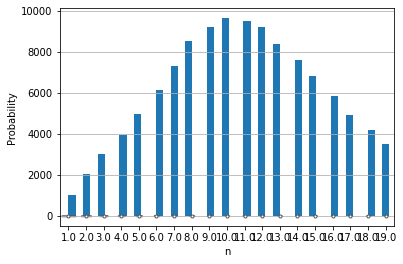

Building adjacency matrix for top 3 cells per spot...
Done.
Plotting...


<Figure size 432x288 with 0 Axes>

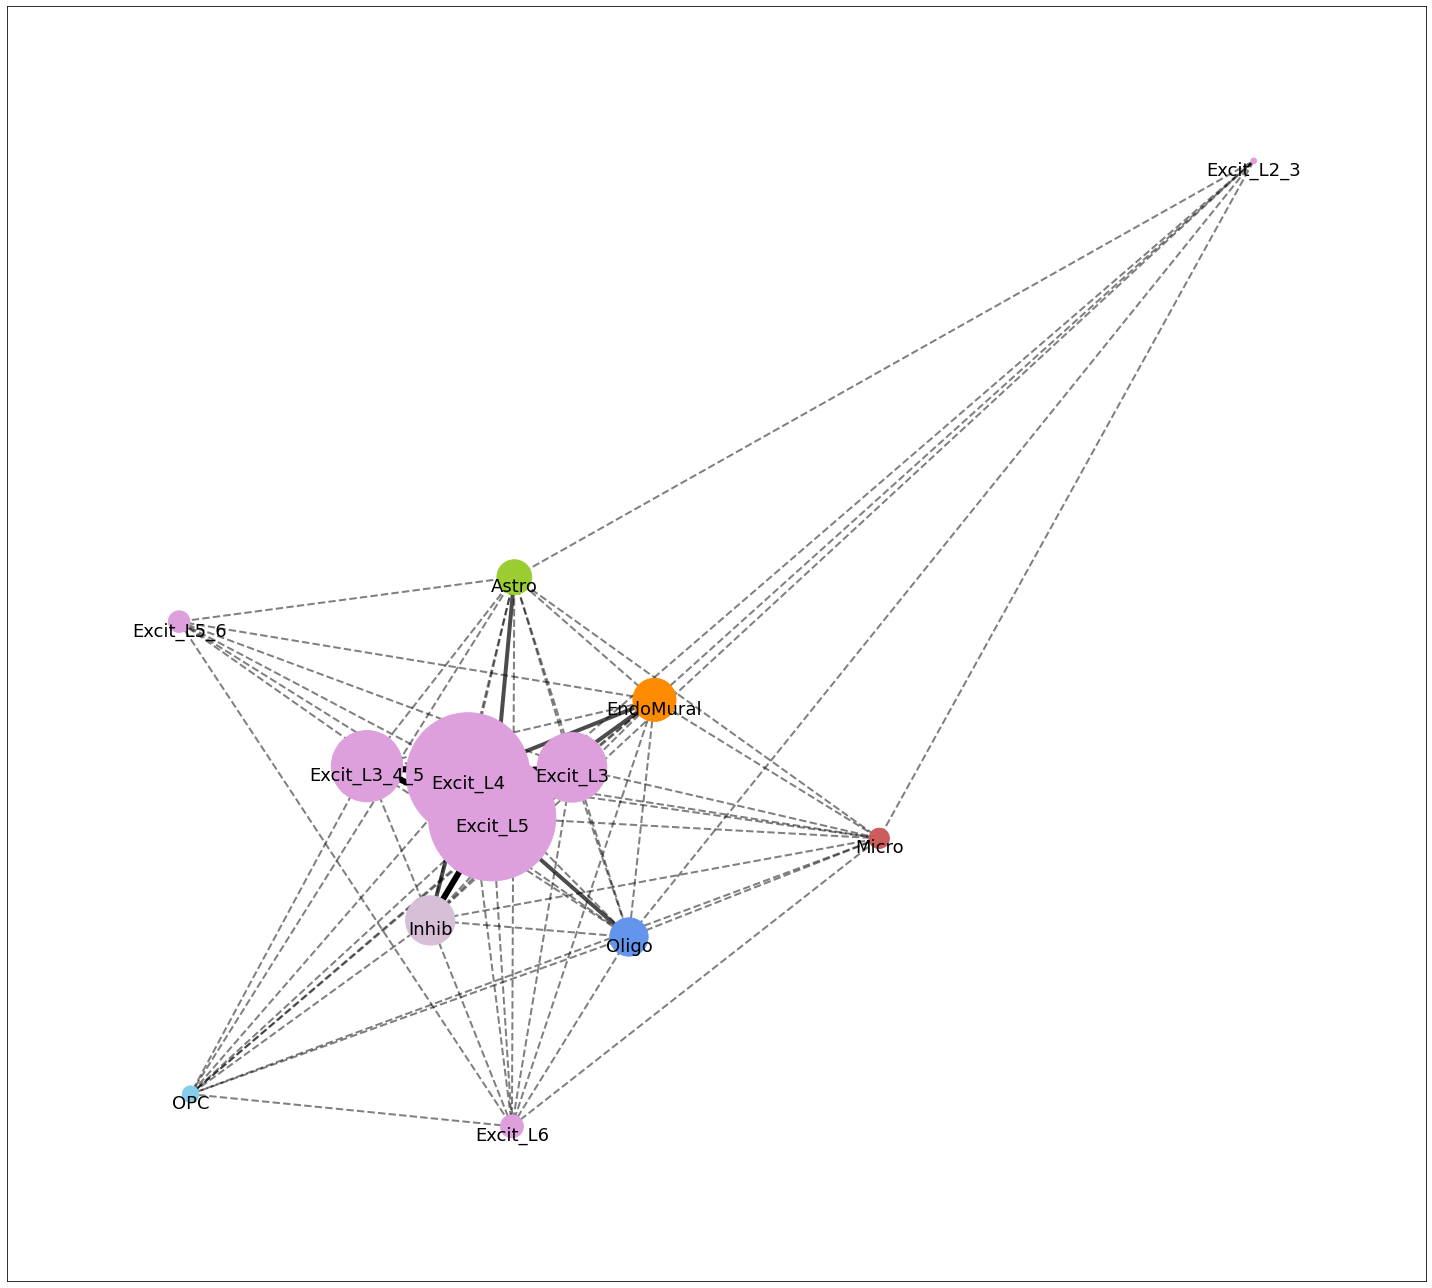

Done.
PageRank is:
                     0
Excit_L5      0.293481
Excit_L4      0.270391
Excit_L3_4_5  0.089905
Excit_L3      0.087232
Inhib         0.052259
EndoMural     0.045926
Oligo         0.039574
Astro         0.034316
Excit_L6      0.020138
Micro         0.019332
Excit_L5_6    0.018766
OPC           0.016437
Excit_L2_3    0.012241


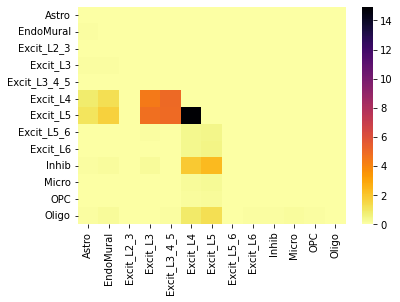

Calculating cumulative probability...
Done


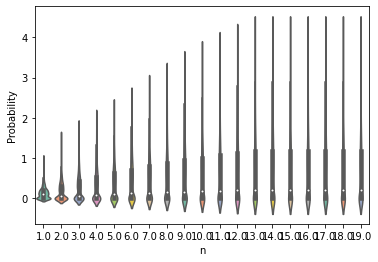

Building adjacency matrix for top 3 cells per spot...
Done.
Plotting...


<Figure size 432x288 with 0 Axes>

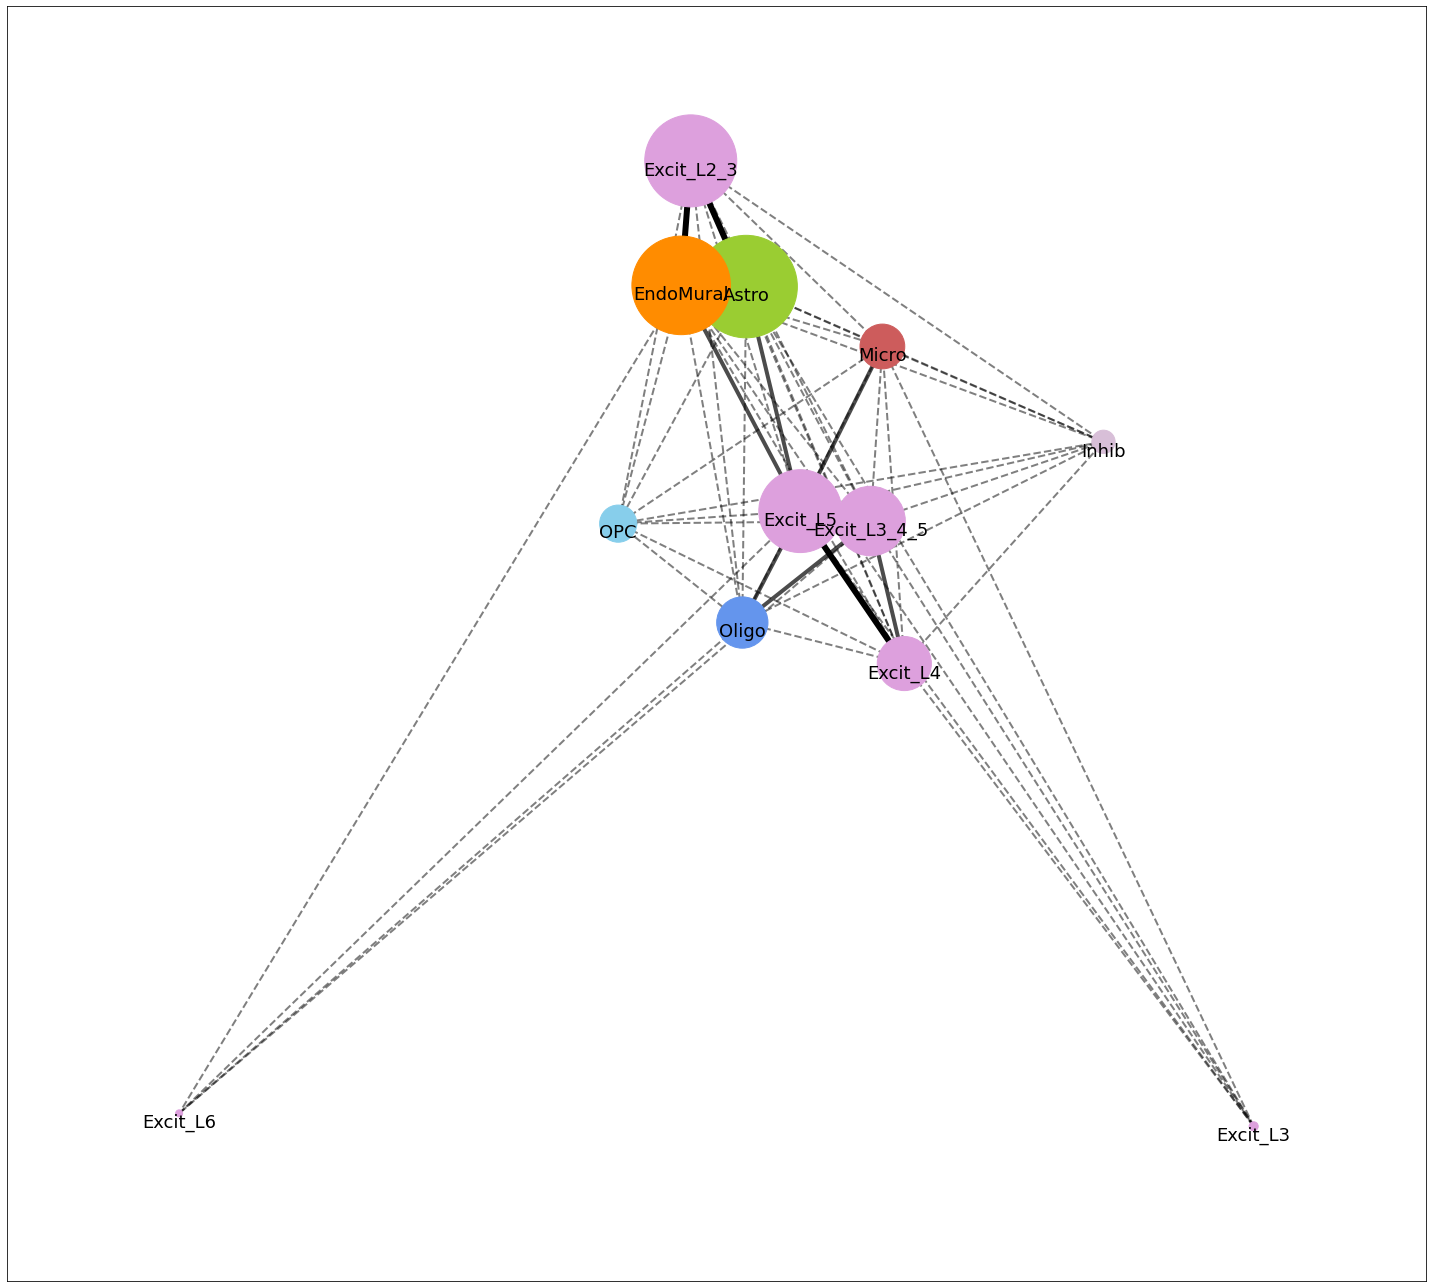

Done.
PageRank is:
                     0
Astro         0.164984
Excit_L5      0.157044
EndoMural     0.150585
Excit_L2_3    0.125757
Excit_L3_4_5  0.110956
Excit_L4      0.072924
Oligo         0.065707
Micro         0.051225
OPC           0.038484
Inhib         0.022817
Excit_L3      0.013904
Excit_L6      0.013268
Excit_L5_6    0.012346


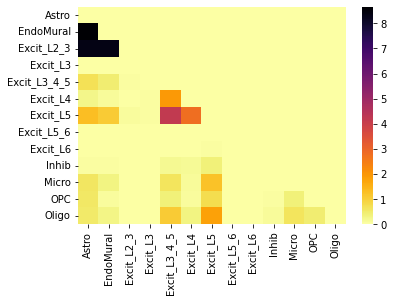

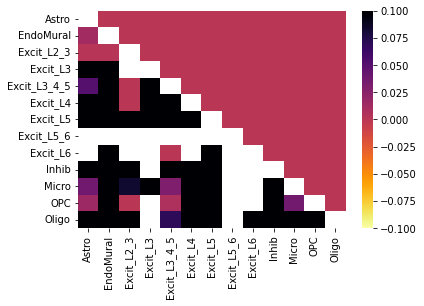

/tmp/slurm_54909784/ipykernel_170761/572713077.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[adata.var[gene].index[0]] = (adata.to_df()[adata.var[gene].index]>0).astype(int)
/tmp/slurm_54909784/ipykernel_170761/572713077.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[adata.var[gene].index[0]] = (adata.to_df()[adata.var[gene].index]>0).astype(int)
/tmp/slurm_54909784/ipykernel_170761/572713077.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

578
66.82080924855491
Calculating cumulative probability...
Done


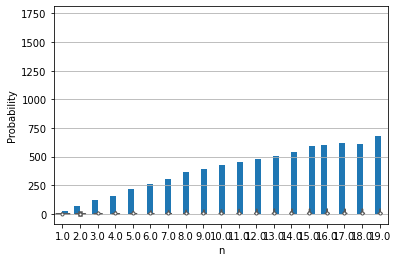

Building adjacency matrix for top 3 cells per spot...
Done.
Plotting...


<Figure size 432x288 with 0 Axes>

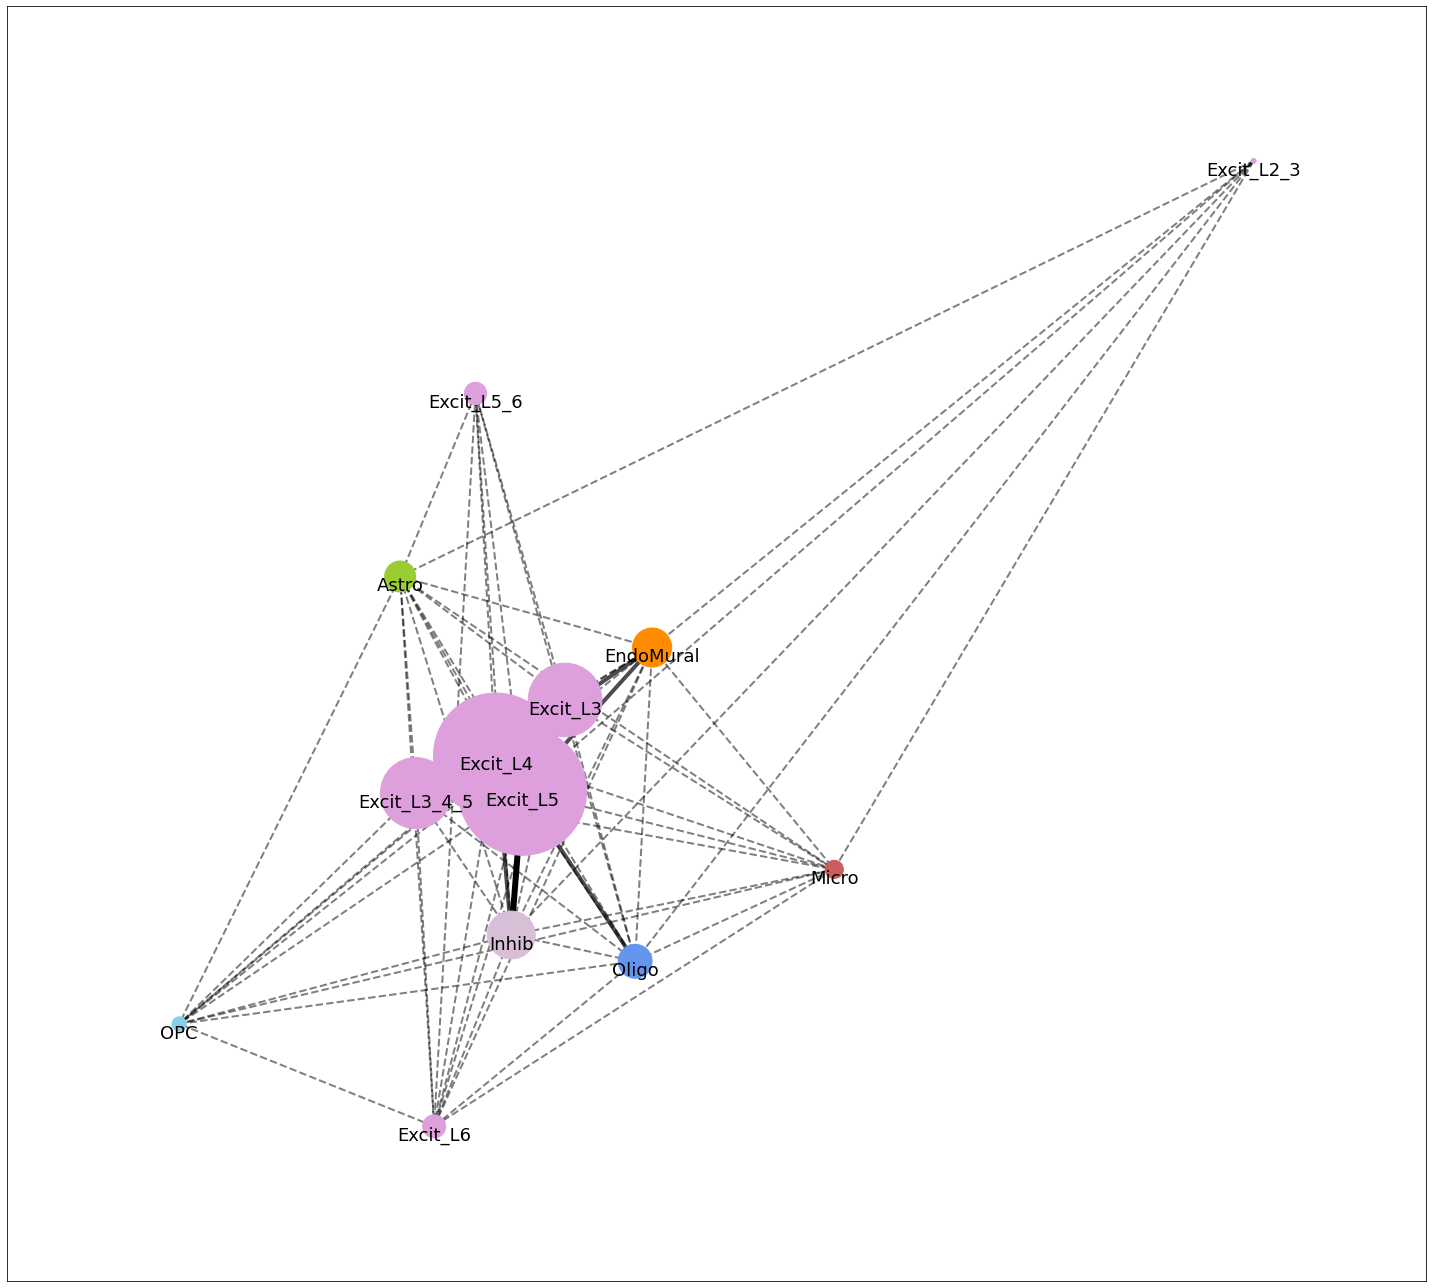

Done.
PageRank is:
                     0
Excit_L5      0.298440
Excit_L4      0.277711
Excit_L3      0.096446
Excit_L3_4_5  0.089080
Inhib         0.049973
EndoMural     0.039877
Oligo         0.033632
Astro         0.030042
Excit_L6      0.020324
Excit_L5_6    0.019272
Micro         0.018051
OPC           0.015064
Excit_L2_3    0.012087


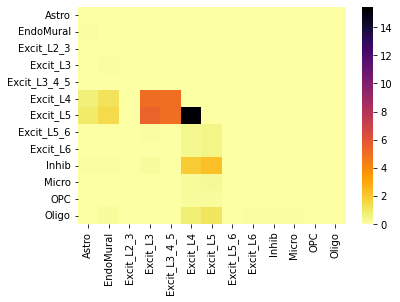

Calculating cumulative probability...
Done


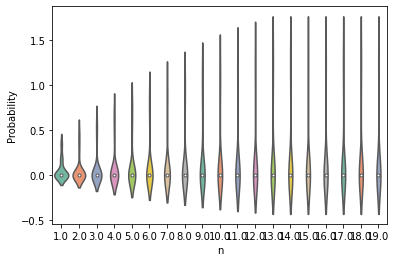

Building adjacency matrix for top 3 cells per spot...
Done.
Plotting...


<Figure size 432x288 with 0 Axes>

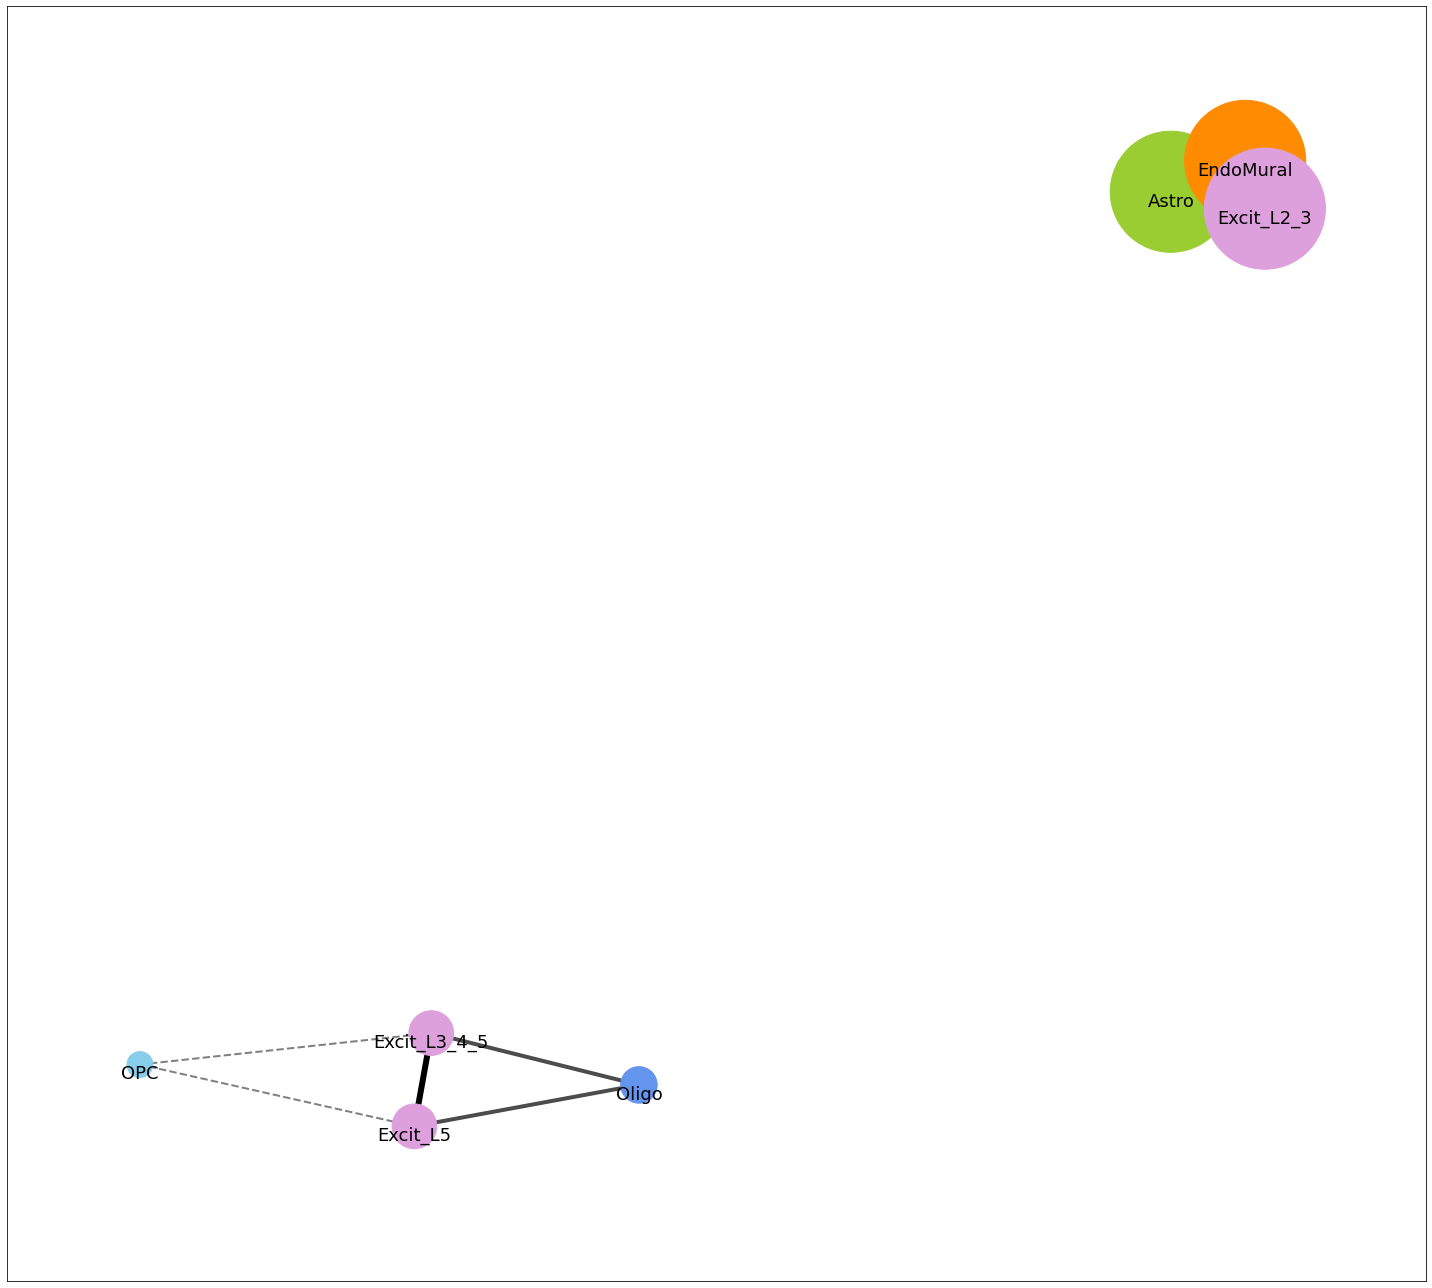

Done.
PageRank is:
                     0
Excit_L3_4_5  0.164335
Excit_L5      0.164335
Astro         0.126582
EndoMural     0.126582
Excit_L2_3    0.126582
Oligo         0.112110
OPC           0.065549
Excit_L3      0.018988
Excit_L4      0.018988
Excit_L5_6    0.018988
Excit_L6      0.018988
Inhib         0.018988
Micro         0.018988


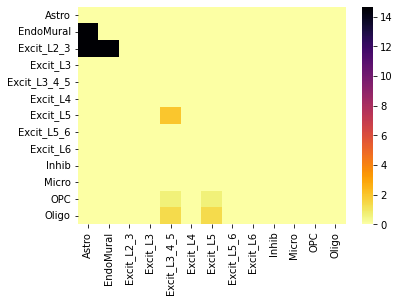

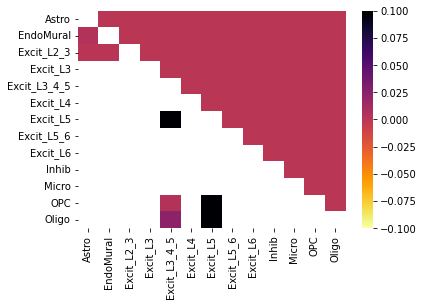

/tmp/slurm_54909784/ipykernel_170761/572713077.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[adata.var[gene].index[0]] = (adata.to_df()[adata.var[gene].index]>0).astype(int)
/tmp/slurm_54909784/ipykernel_170761/572713077.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[adata.var[gene].index[0]] = (adata.to_df()[adata.var[gene].index]>0).astype(int)
/tmp/slurm_54909784/ipykernel_170761/572713077.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

802
66.28099173553719
Calculating cumulative probability...
Done


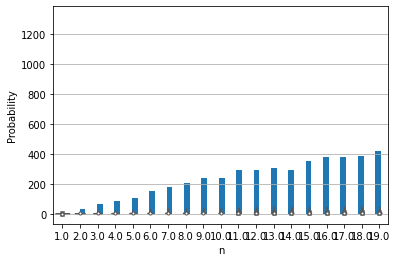

Building adjacency matrix for top 3 cells per spot...
Done.
Plotting...


<Figure size 432x288 with 0 Axes>

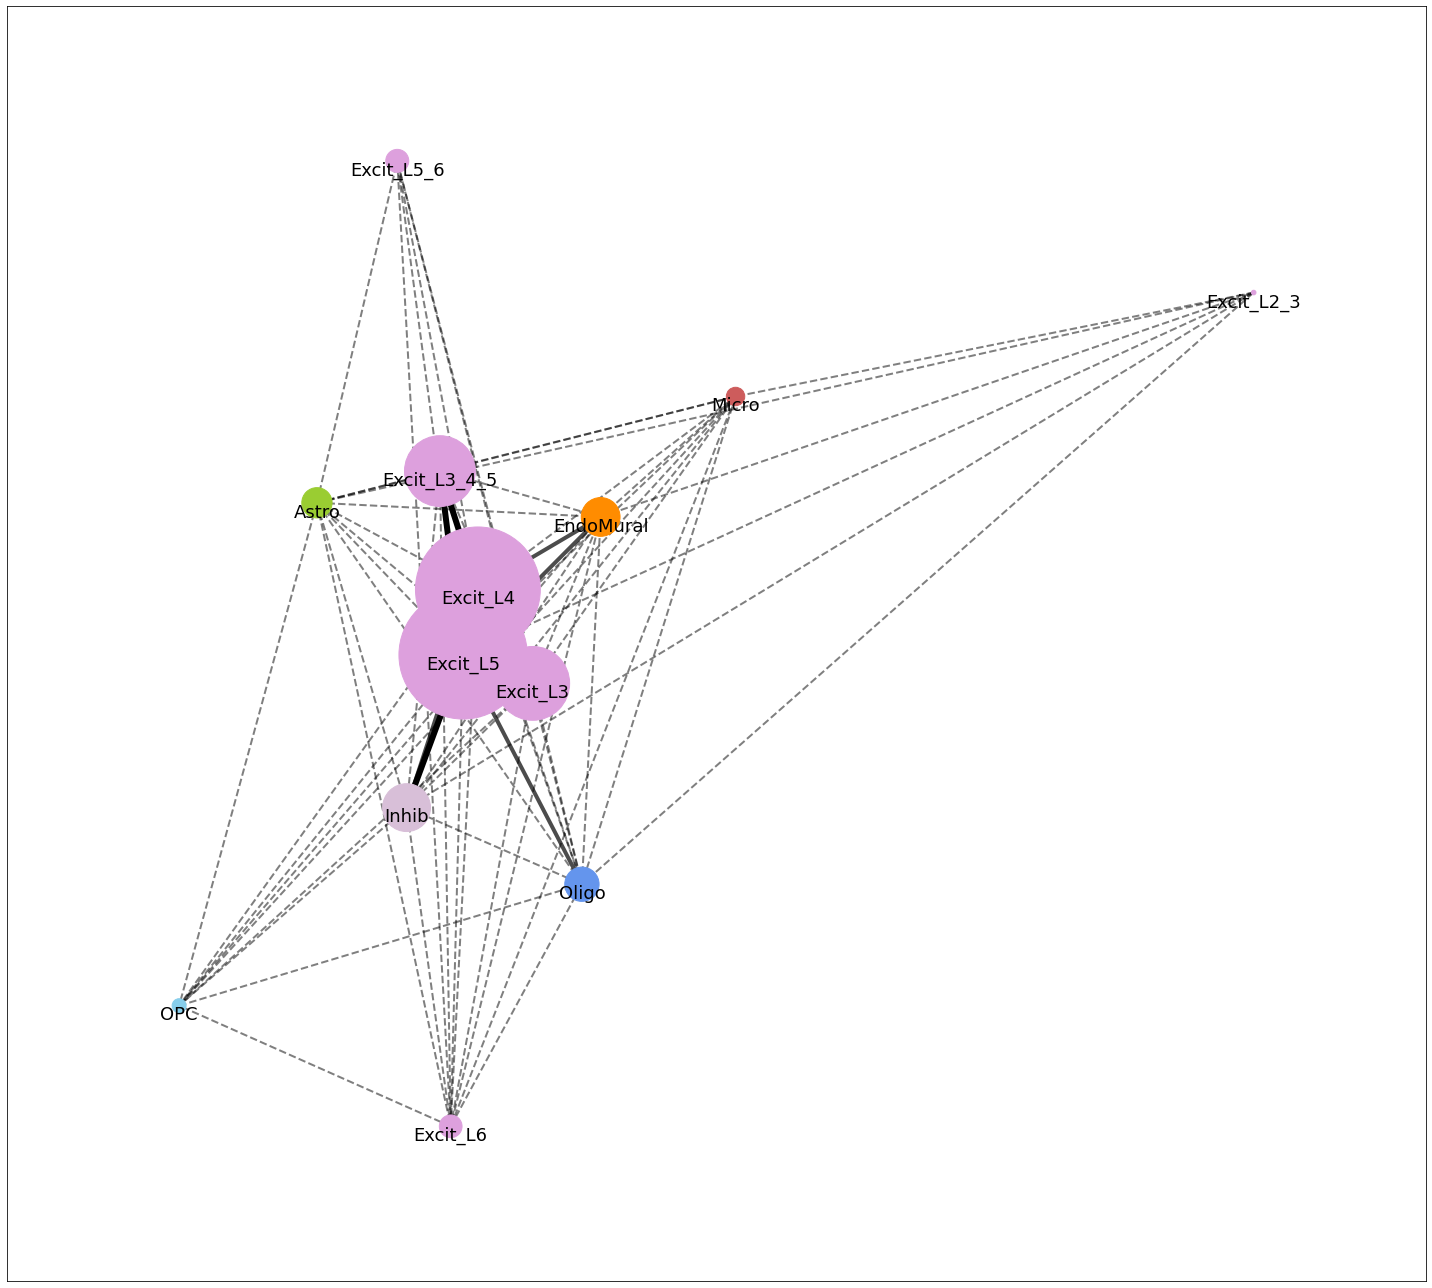

Done.
PageRank is:
                     0
Excit_L5      0.298080
Excit_L4      0.278102
Excit_L3      0.096702
Excit_L3_4_5  0.088496
Inhib         0.049506
EndoMural     0.039897
Oligo         0.034327
Astro         0.029646
Excit_L6      0.020068
Excit_L5_6    0.019760
Micro         0.018338
OPC           0.015029
Excit_L2_3    0.012050


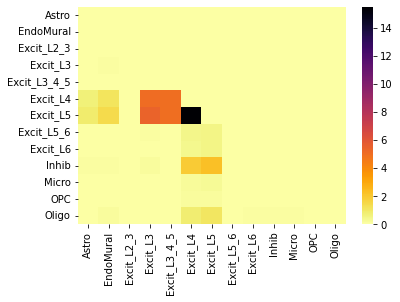

Calculating cumulative probability...
Done


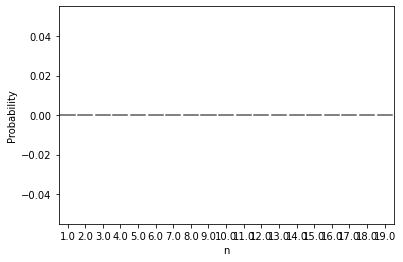

Building adjacency matrix for top 3 cells per spot...
Done.
Plotting...


<Figure size 432x288 with 0 Axes>

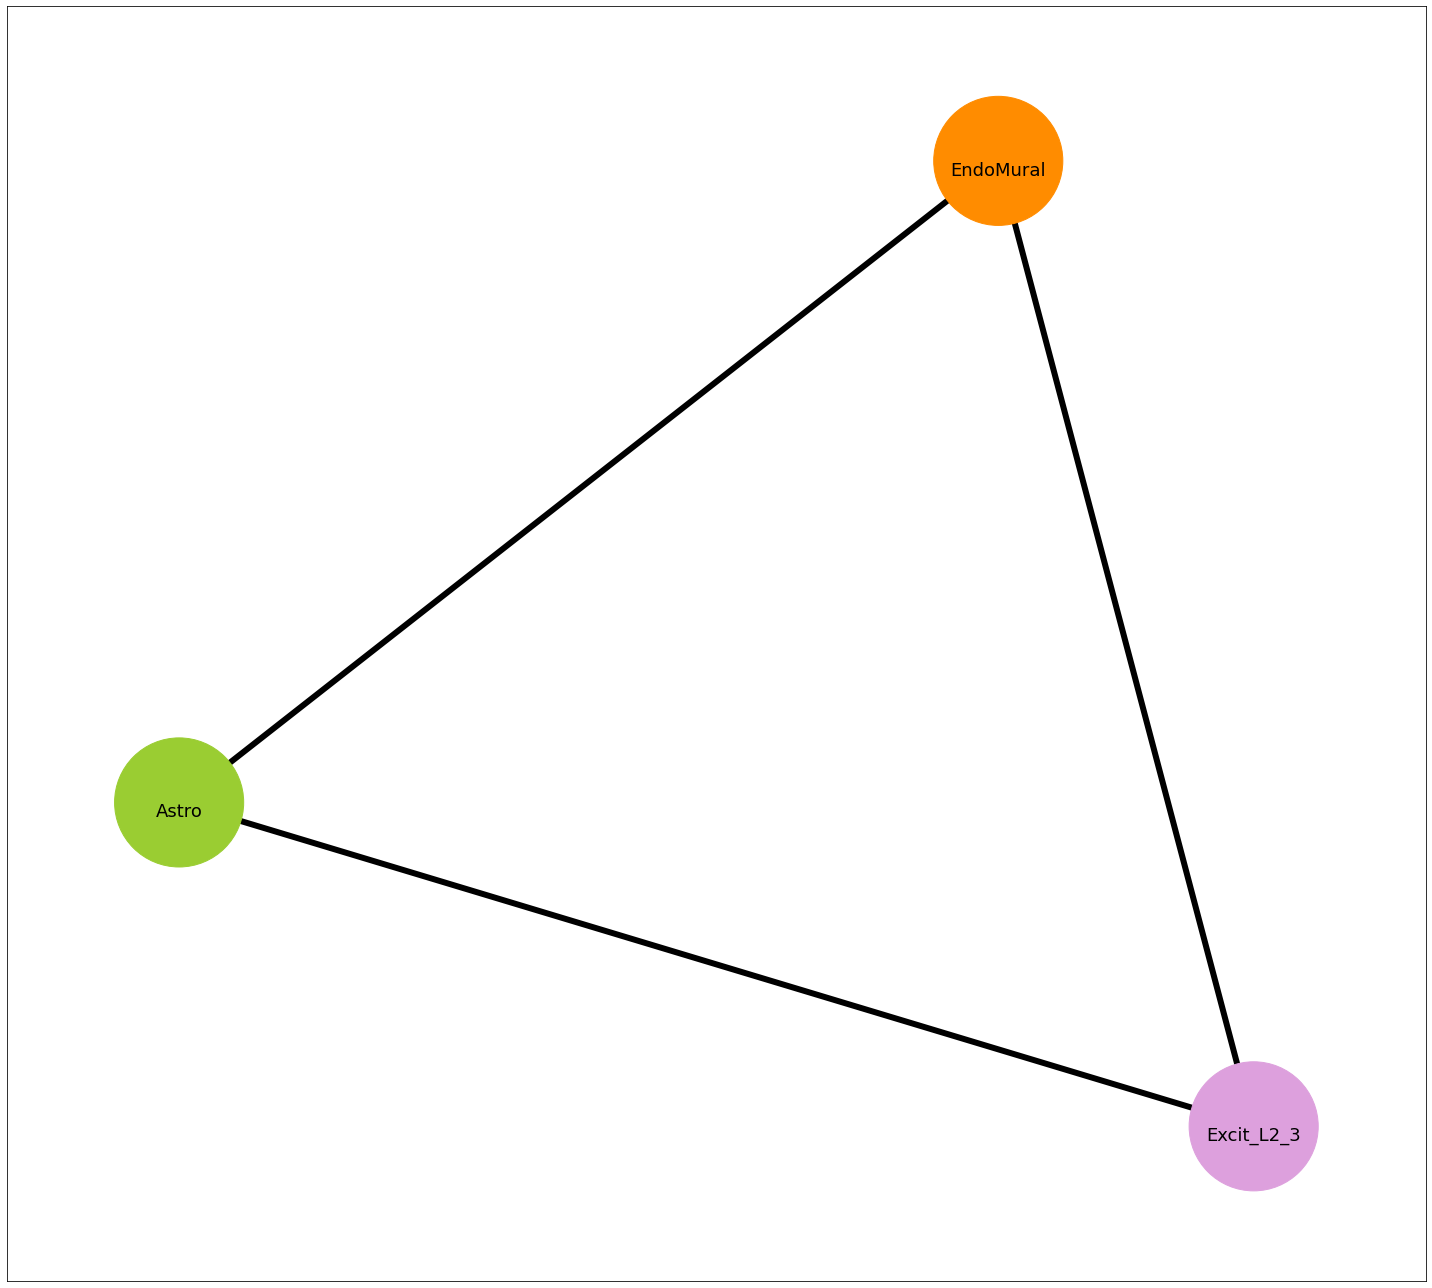

Done.
PageRank is:
                     0
Astro         0.222219
EndoMural     0.222219
Excit_L2_3    0.222219
Excit_L3      0.033334
Excit_L3_4_5  0.033334
Excit_L4      0.033334
Excit_L5      0.033334
Excit_L5_6    0.033334
Excit_L6      0.033334
Inhib         0.033334
Micro         0.033334
OPC           0.033334
Oligo         0.033334


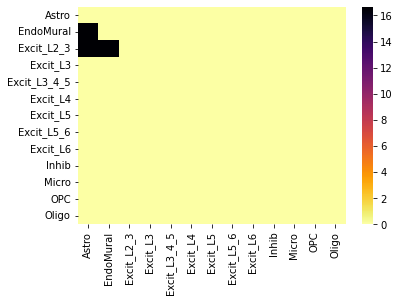

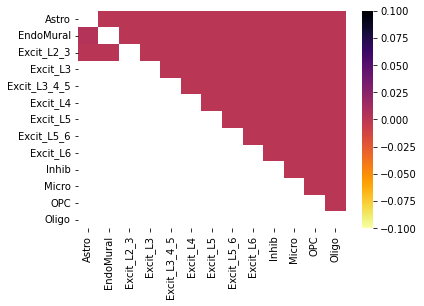

<Figure size 432x288 with 0 Axes>

In [13]:
###--------------------------------------------RUN ANALYSIS FOR TOP 3 CELLS

def list_counts_from_pandas(df, lst):
    return df[lst].value_counts().to_frame().reset_index().rename({0:'n'}, axis=1)

res = ['0.7', '0.55', '0.4']
iter = 1
pvals=[]
qtl = 0.95
for n in range(0,len(res)):
    top = pd.read_csv('processed_data/03-LR_network_visualisation/louvain_largest_cluster_%s.csv' % res[n], sep = ',', index_col = 0)
    pvals=[]
    df = coloc_LR_list(adata, list(top['0']), res[n])
    interest = adata[adata.obs.index.isin(df['sum'][df['sum']>df['sum'].quantile(q=qtl)].index)]
    interest.obs['bayesSpace_harmony_9'] = interest.obs['bayesSpace_harmony_9'].cat.rename_categories({1: 'SpD1 ~ L1', 
                                                         2 : 'SpD2 ~ L1', 
                                                         3 : 'SpD3 ~ L2', 
                                                         4 : 'SpD4 ~ L5', 
                                                         5 : 'SpD5 ~ L3', 
                                                         6 : 'SpD6 ~ WM', 
                                                         7 : 'SpD7 ~ L6', 
                                                         8 : 'SpD8 ~ L4', 
                                                         9 : 'SpD9 ~ WM'})

    def list_counts_from_pandas(df, lst):
        return df[lst].value_counts().to_frame().reset_index().rename({0:'n'}, axis=1)

    all_clust = list_counts_from_pandas(interest.obs, ['sample_id', 'bayesSpace_harmony_9'])
    total_patient = list_counts_from_pandas(interest.obs, ['sample_id'])
    all_clust.rename(columns = {'n':'All'}, inplace = True)
    perc = []


    print("Appending %")
    for l in range (0,np.shape(all_clust)[0]):
        perc.append(100*all_clust['All'][l]/np.shape(interest[interest.obs['sample_id']==all_clust['sample_id'][l]])[0])

    all_clust['layer of top network-expressing spots per sample (%)'] = perc
    
    
    plt.figure(figsize=(10,5), dpi = 300)
    sns.boxplot(data=all_clust, x="bayesSpace_harmony_9", y="layer of top network-expressing spots per sample (%)", showfliers=False, order = ['SpD1 ~ L1', 'SpD2 ~ L1', 'SpD3 ~ L2','SpD5 ~ L3','SpD8 ~ L4', 'SpD4 ~ L5', 'SpD7 ~ L6', 'SpD6 ~ WM', 'SpD9 ~ WM'])
    plt.xticks(rotation=90)
    plt.savefig("plots/03-LR_network_visualisation/03h_spatial_colocalisation/%s_boxplot_c2l_top5pct_perlayer.png" % (res[n]), bbox_inches = 'tight')
    plt.show()

    all_clust.to_csv('processed_data/03-LR_network_visualisation/03h_spatial_colocalisation/%s_layer_percentages_top5pct.csv' % (res[n]), )
    
    LRadjmat, cell_counts = network_top3(interest, 'LR_'+res[n])
    
    for i in range(0,iter):
        number_spots = len(interest.obs.index)
        rand_spots = random.sample(list(adata.obs.index), number_spots)
        hot1 = hot1_encode_cell_counts(adata[adata.obs.index.isin(rand_spots)])
        if (i == 0):
            bootstrapped = hot1.sum()
        else:
            bootstrapped = pd.concat([bootstrapped, hot1.sum()], axis = 1)
    bootstrapped = bootstrapped.T
    counts = pd.DataFrame(cell_counts).T
    for celltype in hot1.columns:
        pvals.append((bootstrapped[celltype]>counts[celltype][0]).sum()/iter)
    final_pvals = pd.DataFrame(np.asarray(pvals).reshape(1,-1), columns = hot1.columns)
    final_pvals.to_csv("processed_data/03-LR_network_visualisation/03h_spatial_colocalisation/%s_bootstrapped_cell_type_pvals.csv" % (res[n]))


In [ ]:
 interest = adata[adata.obs.index.isin(df['sum'][df['sum']>df['sum'].quantile(q=qtl)].index)]
    interest.obs['bayesSpace_harmony_9'] = interest.obs['bayesSpace_harmony_9'].cat.rename_categories({1: 'SpD1 ~ L1', 
                                                     2 : 'SpD2 ~ L1', 
                                                     3 : 'SpD3 ~ L2', 
                                                     4 : 'SpD4 ~ L5', 
                                                     5 : 'SpD5 ~ L3', 
                                                     6 : 'SpD6 ~ WM', 
                                                     7 : 'SpD7 ~ L6', 
                                                     8 : 'SpD8 ~ L4', 
                                                     9 : 'SpD9 ~ WM'})


    all_clust = list_counts_from_pandas(interest.obs, ['sample_id', 'bayesSpace_harmony_9'])
    total_patient = list_counts_from_pandas(interest.obs, ['sample_id'])
    all_clust.rename(columns = {'n':'All'}, inplace = True)
    perc = []


    print("Appending %")
    for m in range (0,np.shape(all_clust)[0]):
        perc.append(100*all_clust['All'][n]/np.shape(interest[interest.obs['sample_id']==all_clust['sample_id'][m]])[0])
    
    all_clust['network-expressing spots per sample (%)'] = perc

    plt.figure(figsize=(10,5), dpi = 300)
    sns.boxplot(data=all_clust, x="bayesSpace_harmony_9", y="network-expressing spots per sample (%)", showfliers=False, order = ['SpD1 ~ L1', 'SpD2 ~ L1', 'SpD3 ~ L2','SpD5 ~ L3','SpD8 ~ L4', 'SpD4 ~ L5', 'SpD7 ~ L6', 'SpD6 ~ WM', 'SpD9 ~ WM'])
    plt.xticks(rotation=90)
    plt.savefig("plots/03-LR_network_visualisation/03h_spatial_colocalisation/%s_boxplot_c2l_top2pct_perlayer.png" % (res[n]))
    plt.show()